## Step 1
Imports and initialisation of a LJ calculator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones

lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box.
Parameters:
- 19 LJ atoms
- Side length = 12

### Box side length
12 Å seems to work with no issues, sufficiently large to house all of the atoms.

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters typically containing 2 - 6 atoms. ![test_minimisation](./images/test_min.png)


This is because the atoms are so far apart, the force between particles is negligible, and so they will rarely converge to form a single cluster. 

So instead of randomising the particles across the entire simulation box, I have restricted the random distribution to a theoretical box occupying the centre of the simuation box that is half the size.

In [2]:
def initialise_structure(n, box_length):
    '''
    n: int, number of atoms to place in the simulation box
    box_length: int/float, box side length in Å
    '''

    cell = np.eye(3)*box_length # 3x3 matrix with box_length across the diagonal
    atoms = ase.Atoms(pbc=True, cell = cell) #Atoms object which creates simulation box and contain all atoms
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired cluster as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates random coordinates restricted to the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos)) #add atom to Atoms object

    return atoms

In [3]:
n = 19 # number of LJ atoms
box_length = 12 # box side length

lj_19 = initialise_structure(19, 12)
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted".

`steps = 1024` seems more than sufficient for the test system. After repeated tests it seems that the system rarely requires above 500 steps to minimise. Indeed, one could limit steps to ~ 600-700, as those that require more than ~ 700 steps likely wont minimise before 1024, though I have seen some cases where they do, so 1024 seems a reasonable buffer.

In [4]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    '''
    atoms: Atoms object, contains structure for minimisation
    f_max: float, atomic force threshold below which structure is sufficiently minimised 
    steps: int, maximum number of minimisation steps before exiting minimisation
    '''

    atoms.calc = lj_calc #assigning LJ calculator to Atoms object
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the Atoms object
    return dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 22:53:21     1673.461023    20905.032474
BFGS:    1 22:53:21        4.088342      192.240825
BFGS:    2 22:53:21       35.333686      746.658586
BFGS:    3 22:53:21       -4.863847       69.438222
BFGS:    4 22:53:21       -6.249750       47.711992
BFGS:    5 22:53:21       -6.691621       30.324741
BFGS:    6 22:53:21       -8.890537       37.011510
BFGS:    7 22:53:21       -8.496573       32.306736
BFGS:    8 22:53:21      -10.901705        5.355601
BFGS:    9 22:53:21      -11.960701        3.545773
BFGS:   10 22:53:21        1.440652      168.426833
BFGS:   11 22:53:21      -12.868940        3.678221
BFGS:   12 22:53:21      -13.501945        3.476787
BFGS:   13 22:53:21       -9.849434       52.263774
BFGS:   14 22:53:21      -14.523396        3.975370
BFGS:   15 22:53:21      -15.199883        4.339387
BFGS:   16 22:53:21      -10.125043       61.311443
BFGS:   17 22:53:21      -15.747570       10.514857
BFGS:   18 22:

np.True_

In [5]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time.

In [6]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = [] #array to store all of the minimised energies as they are generated
structures = [] #array to store all the final Atoms objects after minimisation

failed = [] # array to store the indecies of any failed minimisations 

'''
for 100 iterations, initialise a simulation box, conduct an energy minimisation,
then store the results in the `energies` and `structures` arrays. If fmax fails
to cross the threshold before reaching the maximum number of steps, append index
of the minimisation to the `failed` array for inspection.
'''
for i in range(100):

    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimisation = minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    if not minimisation:
        failed.append(i)

      Step     Time          Energy          fmax
BFGS:    0 22:53:22 4128982120.612745 279370599358.175537
BFGS:    1 22:53:22     2967.726018    59475.388677
BFGS:    2 22:53:22     2801.192898    59475.388514
BFGS:    3 22:53:22     2800.010683    59461.610448
BFGS:    4 22:53:22     2819.297588    59434.850215
BFGS:    5 22:53:22     2795.225902    59364.321142
BFGS:    6 22:53:22     2783.668772    59098.134465
BFGS:    7 22:53:22      247.598248     4437.926781
BFGS:    8 22:53:22       -6.613006       31.540788
BFGS:    9 22:53:22       -6.933837       31.170899
BFGS:   10 22:53:22       -7.699536       27.921411
BFGS:   11 22:53:22        2.880247      204.134885
BFGS:   12 22:53:22       -8.893412       18.878817
BFGS:   13 22:53:22       -9.261835       16.726379
BFGS:   14 22:53:22       -9.395199       14.588240
BFGS:   15 22:53:22       -9.273752       12.321386
BFGS:   16 22:53:22       -9.763201       11.562024
BFGS:   17 22:53:22      -10.170940        7.905975
BFGS:   

In [7]:
failed

[30, 47, 68, 96]

On this occasion none of the simulations failed, miraculous! I have observed some that do not minimise within the 1024 steps given, but come close to `fmax`, e.g. `fmax = 0.00436` In light of those cases, it may be more appropriate to increase fmax slightly, to`fmax = 0.005` for example.

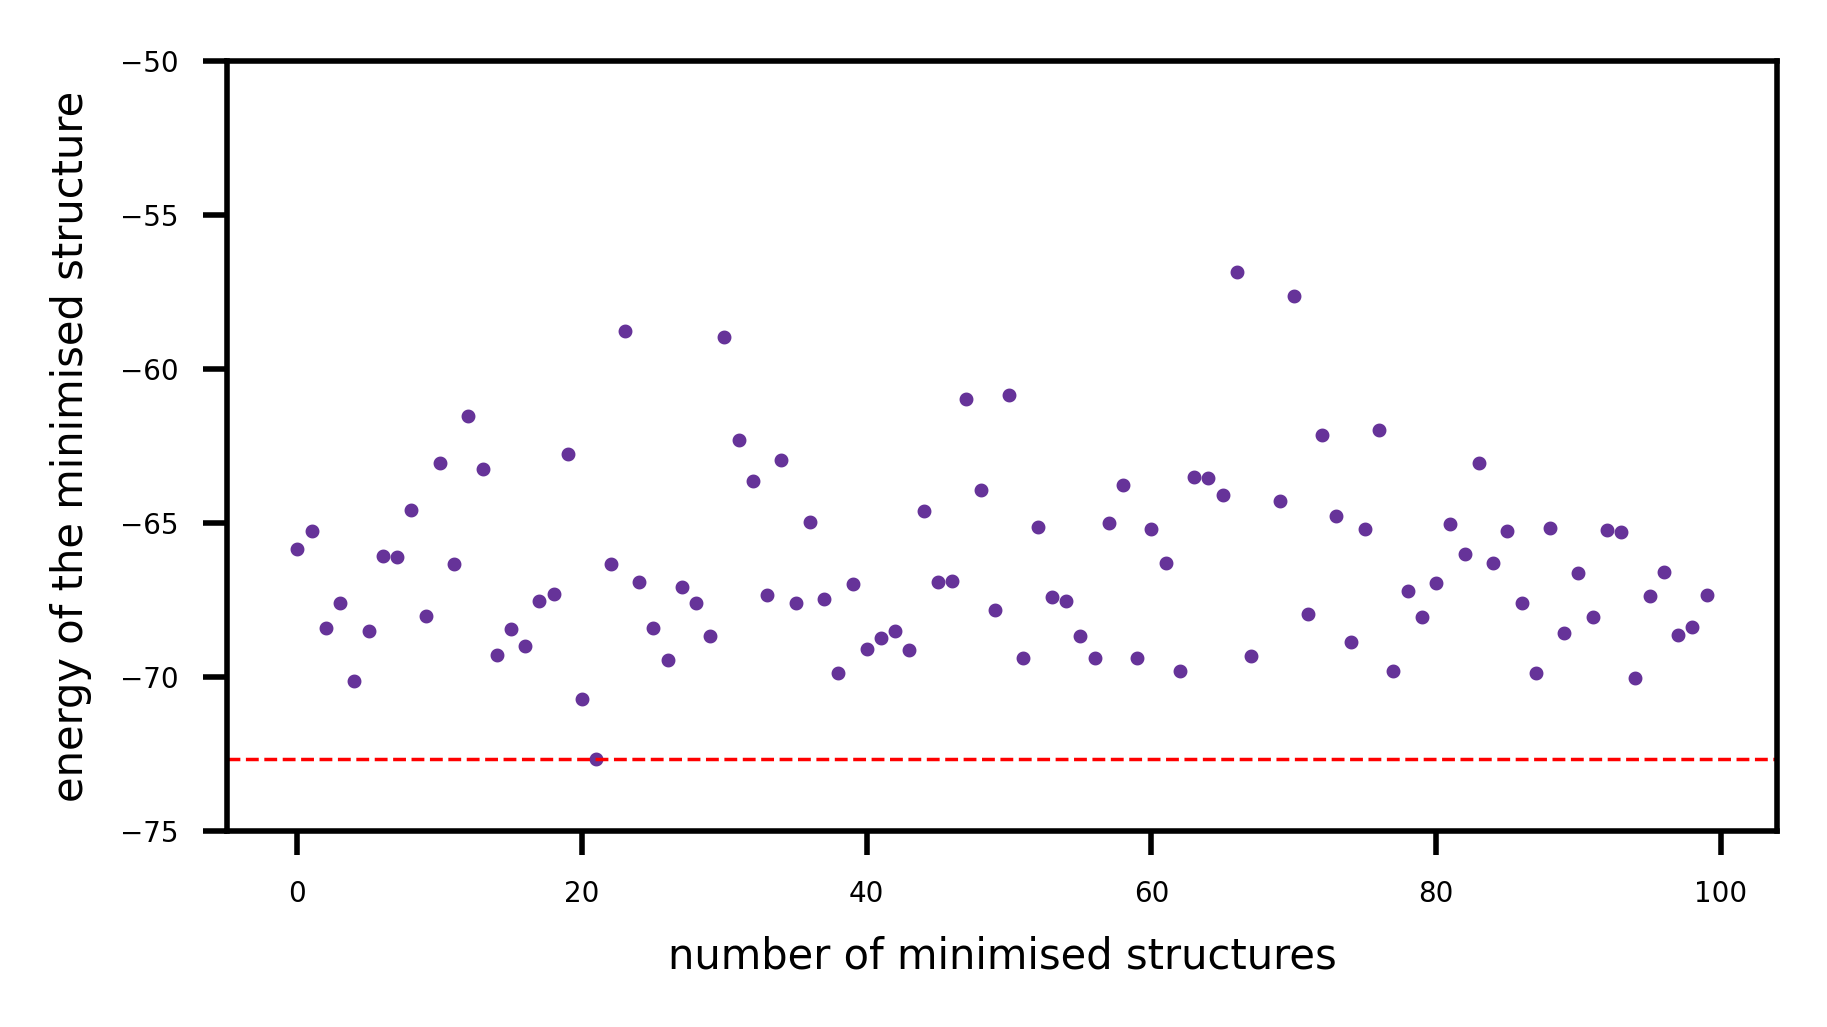

In [8]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.ylim(-75, -50)
plt.axhline(y = -72.659782, color = 'r', linestyle = '--', lw=0.5)
plt.savefig('LJ19_min_test.png')

In [9]:
def enumerate_minima(energies):
    '''
    some function, or indeed collection of functions that can identify the number of different minima we have explored.
    This would require some identification of the uniqueness of each of the simulations, particularly if their energy is very close.
    Extra work I'm not interested in at this moment in particular, maybe closer to the deadline if I have time.

    As a first approximation, I will use the energy values.
    '''

    energies = [round(e, 1) for e in energies]

    return len(set(energies))

enumerate_minima(energies)


59

### Analysis

Here, none of these structures have reached the global minimum, known to be at -72.659782 per atom (the red dashed line). [Some number] of them are below -70. Based on the equivalent energy approximation, we have found 54 unique minima (rounding energies to 1 decimal place).

## Step 5

Implementation of the basin hopping algorithm

In [10]:
def perturb_structure(atoms, method = 'wild', magnitude = 3.0, k = 3):
    '''
    Pertubation Methods
    '''
    def wild(atoms=atoms, magnitude=magnitude):
        '''
        'wild' randomly selects one atom and moves it in a random direction by a random distance. The distance
        is randomly distributed between 0.0 and the `magnitude` variable.
        '''
        atom_index = np.random.randint(len(atoms) - 1) #selects a random atom from the cluster

        rng = np.random.default_rng() #initialising random number generator
        direction = rng.normal(size = 3) #randomising the direction the selected atom will be moved
        direction /= np.linalg.norm(direction, keepdims = True) #normalising to produce a unit vector
        length = np.random.uniform(low = 0.0, high = magnitude) #random magnitude between 0 and the specified magnitude
        atoms.positions[atom_index] += direction * length # apply transformation of coordinates to the selected atom
        
        return atoms
    
    def stretch(atoms=atoms, magnitude = magnitude):
        '''
        'stretch' calculates the centroid of the cluster, then moves all the atoms away from that centroid.
        Each of the atoms is moved by a random distance, randomly distributed between 0.0 and the 
        '''
        centroid = np.mean(atoms.positions, axis = 0) #determine the center of all the atoms
        vectors = atoms.positions - centroid # compute the vector that points from the centroid to each atom
        norms = np.linalg.norm(vectors, axis = 1) # compute the norms for the vectors
        mask = norms > 0.0 # mask so that we don't divide by 0, in case one of the atoms is exactly at the centroid
        unit_vectors = vectors[mask]/norms[mask, None] # normalise to produce unit vectors pointing away from the centroid for each atom

        # randomise the lengths of all the vectors, between 0 and the specified magnitude
        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (unit_vectors.shape[0], 1)) 
        
        atoms.positions += unit_vectors * lengths # apply transformation to all the atom positions
        
        return atoms

    def sweep(atoms=atoms, magnitude=magnitude, k=3):
        '''
        'sweep' determines the k-furthest atoms from the cluster centroid, and moves each
        of these atoms in a random direction by a random distance, randomly distributed between
        0.0 and the `magnitude` variable. Based on the idea that the core of the cluster is likely
        stable, but the outermost atoms are those that need to be displaced.
        '''

        # Computing distance from centre of the cluster
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        distances = np.linalg.norm(vectors, axis = 1)
        
        #identifying the k-furthest atoms from the centre of the cluster
        idx = np.argsort(distances)[-k:][::-1]

        rng = np.random.default_rng()
        directions = rng.normal(size = (len(idx), 3)) #randomising the directions each of the k-furthest atoms will be moved
        directions /= np.linalg.norm(directions, axis=1, keepdims = True) #normalising to produce the unit vector
        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (directions.shape[0], 1)) #random magnitudes
        
        atoms.positions[idx] += directions * lengths
        return atoms
    
    def swap(atoms):
        '''
        'swap' exchanges two random atoms coordinates, but only one component. e.g. randomly swap the x coordinate
        of atom a with the z coordinate of atom b, or randomly swap the y coordinate of atom a with the y coordinate
        of atom b.
        '''
        rng = np.random.default_rng() # initialising random number generator
        n = len(atoms) # number of atoms

        # randomising the atoms selected
        atom_a = rng.integers(0, n)
        atom_b = rng.integers(0, n)

        # randomising the x, y, z coordinates to be swapped
        comp_a = rng.integers(0, 3)
        comp_b = rng.integers(0, 3)

        #simultaneously exchange the coords of atoms a and b
        atoms.positions[atom_a, comp_a], atoms.positions[atom_b, comp_b] = atoms.positions[atom_b, comp_b], atoms.positions[atom_a, comp_a]

        return atoms

    if method == 'wild':
        return wild(atoms, magnitude)
        
    elif method == 'stretch':
        return stretch(atoms, magnitude)

    elif method == 'sweep':
        return sweep(atoms, magnitude, k)
    
    elif method == 'swap':
        return swap(atoms)
    


In [11]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []
failed = []
minima = [] #array to store only the minima that is lower in energy than any previously explored minima

global_min = float('inf') #initialising global minimum variable

for i in range(100):
    # for the first iteration, initialise a random structure
    if i == 0:
        lj_19 = initialise_structure(n = n, box_length = box_length) 
    
    # for subsequent iterations, perturb a copy of the minimum structure
    else:
        lj_19 = perturb_structure(minimum.copy(), method = 'swap')

    minimisation = minimise_structure(lj_19, id = i)

    if not minimisation:
        failed.append(i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    # minimum variable stores the structure with the lowest energy
    if energy < global_min:
        global_min = energy # replace global_min variable with new lowest energy
        minimum = lj_19.copy()
        minima.append(minimum) #append minimum structure to minima

    

      Step     Time          Energy          fmax
BFGS:    0 22:54:51     3315.772410    71200.030924
BFGS:    1 22:54:51       -3.545110       42.162164
BFGS:    2 22:54:51       -4.584950       42.072592
BFGS:    3 22:54:51       -5.025584       41.856855
BFGS:    4 22:54:51       10.741824      241.075210
BFGS:    5 22:54:51       -5.502808       41.057315
BFGS:    6 22:54:51       -6.192087       38.528156
BFGS:    7 22:54:51       -9.535673        9.066392
BFGS:    8 22:54:51       -3.336136      114.113417
BFGS:    9 22:54:51      -10.076874       16.476776
BFGS:   10 22:54:51       -8.562059       10.013585
BFGS:   11 22:54:51       -9.968113        3.227951
BFGS:   12 22:54:51       -6.540493       57.349607
BFGS:   13 22:54:51      -11.001674        3.201686
BFGS:   14 22:54:51      -11.265550       11.762860
BFGS:   15 22:54:51      -11.995524        3.578706
BFGS:   16 22:54:51      -13.251865       10.541769
BFGS:   17 22:54:51      125.149300     2438.486187
BFGS:   18 22:

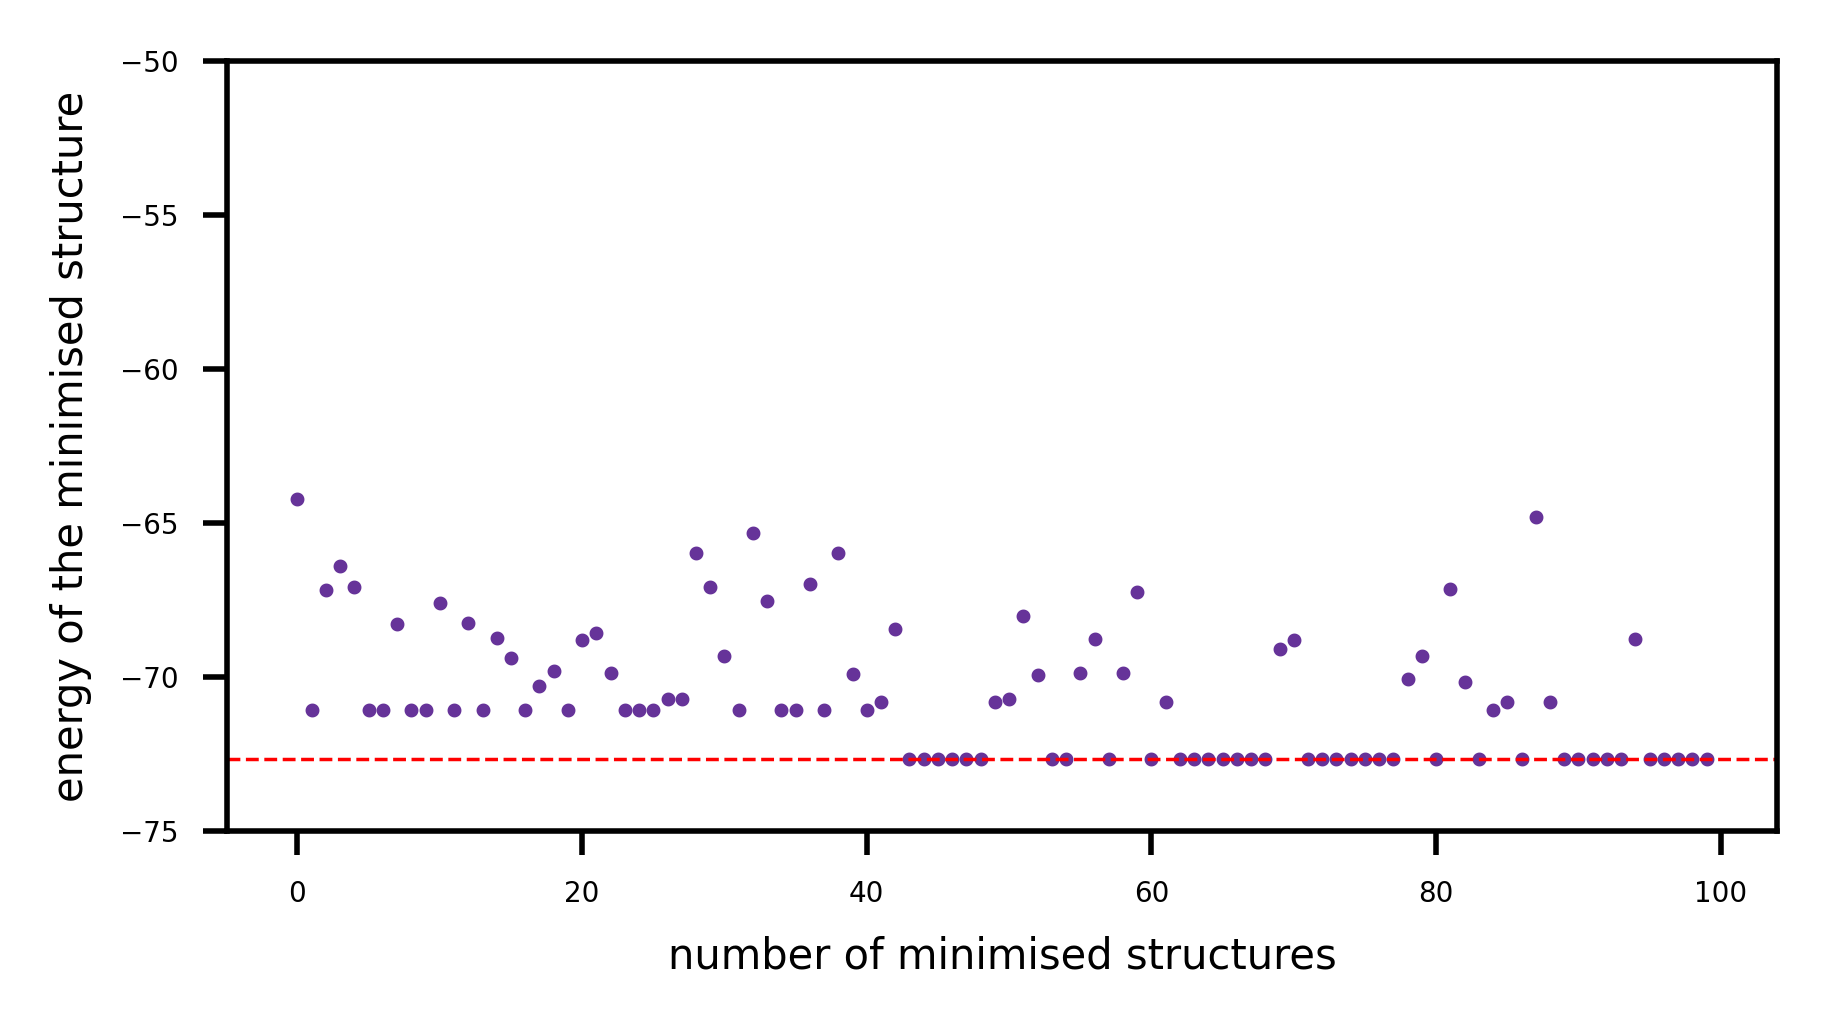

In [12]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.ylim(-75, -50)
plt.axhline(y = -72.659782, color = 'r', linestyle = '--', lw=0.5)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('./images/LJ19_min_demo.png')

In [13]:
view(minima[-1], viewer = 'x3d')

## Analysis of Pertubation Methods

Varied Magnitude of pertubation up from 1.0 up to 12.0 (to be ridiculous)[1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

#### 'Wild'
- pertubation magnitude


#### 'Stretch'
- pertubation magnitude

#### 'Sweep'

Investigate two variables:
- number of atoms to 'sweep' -- from 1 up to 8
- magnitude of pertubation -- from 1.0 up to 12.0 (to be ridiculous)

As magnitude of pertubation increases ...

As the number of atoms perturbed, k, increases, ... 

#### 'Swap'


### Conclusions
The best performing pertubation method was ..., with magnitude = ... (and k = ...) . Generally it was seen that as magnitude of pertubtation was increased, ... . For 'Sweep', where the user could select the number of atoms to perturb, it was seen that was the number of atoms to perturb increased ... .

However it is important to take the conclusions from these results with a pinch of salt, as the 'performance' (being measured as the method that finds the global minimum in the fewest number of iterations) is heavily influenced by the very first minimised structure. e.g. if the first structure minimises to -70 kj mol, in this system it seems that it is much more likely to find the global minimum in fewer iterations, compared to an equivalent method but the first configuration minimises to -60 kj mol-1 instead. A proper investigation should 'sample' the performance by running multiple (e.g. 20) iterations of starting from a new random structure.
